In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re
from wordcloud import WordCloud 
import nltk

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import re, string, unicodedata                          # Import Regex, string and unicodedata.
import contractions                                     # Import contractions library.
from bs4 import BeautifulSoup                           # Import BeautifulSoup.
##      ignore warnings
import warnings
warnings.filterwarnings('ignore')
### Random Forest
from sklearn.ensemble import RandomForestClassifier
### cross validation
from sklearn.model_selection import cross_val_score
#### confusion matrix
from sklearn.metrics import confusion_matrix
### classification report
from sklearn.metrics import classification_report
### accuracy score
from sklearn.metrics import accuracy_score


In [3]:
import easygui

In [4]:
path = easygui.fileopenbox()

In [5]:
path

'/Users/giridharana.r/Desktop/S_Assignments/DATA_245_ML/Project/Tripadvisor_Reviews/CSV/tripadvisor_hotel_reviews.csv'

In [2]:
df = pd.read_csv('/Users/giridharana.r/Desktop/S_Assignments/DATA_245_ML/Project/Tripadvisor_Reviews/CSV/tripadvisor_hotel_reviews.csv')

In [3]:
df.head()

,Review,Rating
0,"nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advantage staying longer, location great walking distance shopping, overall nice experience having pay 40 parking night,",4
1,"ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, start booked suite paid extra website description not, suite bedroom bathroom standard hotel room, took printed reservation desk showed said things like tv couch ect desk clerk told oh mixed suites description kimpton website sorry free breakfast, got kidding, embassy suits sitting room bathroom bedroom unlike kimpton calls suite, 5 day stay offer correct false advertising, send kimpton preferred guest website email asking failure provide suite advertised website reservation description furnished hard copy reservation printout website desk manager duty did not reply solution, send email trip guest survey did not follow email mail, guess tell concerned guest.the staff ranged indifferent not helpful, asked desk good breakfast spots neighborhood hood told no hotels, gee best breakfast spots seattle 1/2 block away convenient hotel does not know exist, arrived late night 11 pm inside run bellman busy chating cell phone help bags.prior arrival emailed hotel inform 20th anniversary half really picky wanted make sure good, got nice email saying like deliver bottle champagne chocolate covered strawberries room arrival celebrate, told needed foam pillows, arrival no champagne strawberries no foam pillows great room view alley high rise building good not better housekeeping staff cleaner room property, impressed left morning shopping room got short trips 2 hours, beds comfortable.not good ac-heat control 4 x 4 inch screen bring green shine directly eyes night, light sensitive tape controls.this not 4 start hotel clean business hotel super high rates, better chain hotels seattle,",2
2,"nice rooms not 4* experience hotel monaco seattle good hotel n't 4* level.positives large bathroom mediterranean suite comfortable bed pillowsattentive housekeeping staffnegatives ac unit malfunctioned stay desk disorganized, missed 3 separate wakeup calls, concierge busy hard touch, did n't provide guidance special requests.tv hard use ipod sound dock suite non functioning. decided book mediterranean suite 3 night weekend stay 1st choice rest party filled, comparison w spent 45 night larger square footage room great soaking tub whirlpool jets nice shower.before stay hotel arrange car service price 53 tip reasonable driver waiting arrival.checkin easy downside room picked 2 person jacuzi tub no bath accessories salts bubble bath did n't stay, night got 12/1a checked voucher bottle champagne nice gesture fish waiting room, impression room huge open space felt room big, tv far away bed chore change channel, ipod dock broken disappointing.in morning way asked desk check thermostat said 65f 74 2 degrees warm try cover face night bright blue light kept, got room night no, 1st drop desk, called maintainence came look thermostat told play settings happy digital box wo n't work, asked wakeup 10am morning did n't happen, called later 6pm nap wakeup forgot, 10am wakeup morning yep forgotten.the bathroom facilities great room surprised room sold whirlpool bath tub n't bath amenities, great relax water jets going,",3
3,"unique, great stay, wonderful time hotel monaco, location excellent short stroll main downtown shopping area, pet friendly room showed no signs animal hair smells, monaco suite sleeping area big striped curtains pulled closed nice touch felt cosy, goldfish n

### EDA

In [4]:
df.shape

(20491, 2)

There are 20491 reviews and 2 columns such as Review and Rating 

In [5]:
df.duplicated().sum()

0

NO duplicates in the dataframe

In [6]:
df["Rating"].value_counts()

5    9054
4    6039
3    2184
2    1793
1    1421
Name: Rating, dtype: int64

Five types of Ratings from 1 - 5 with 1 being the lowest and 5 being the highest

In [7]:
px.histogram(df,x = "Rating",color = "Rating",title = "Hotel Ratings", width=600,height=600)

There are more number of positive reviews than negative reviews on seeing the plot

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


Review is in the object format and Rating is in int format

#### Checking the missing values

In [7]:
def missing(df):
    missing_value = df.isnull().sum().sort_values(ascending=False)
    missing_percentage = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    total_missing = pd.concat([missing_value,missing_percentage],axis=1,keys=["Total Missing","Percentage"])
    
    return total_missing
    

In [8]:
missing(df)

,Total Missing,Percentage
Review,0,0.0
Rating,0,0.0


There are no missing values present in the dataset and all the data are labelled

In [11]:
#### Checking for empty strings

df.loc[df["Review"] == ""]

,Review,Rating


There are no empty strings present

#### Word Cloud of all reviews

In [12]:
def wordCloud_generator(data, title=None):
    wordcloud = WordCloud(width = 800, height = 800,
                          background_color ='black',
                          min_font_size = 10
                         ).generate(" ".join(data.values))
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=30)
    plt.show() 

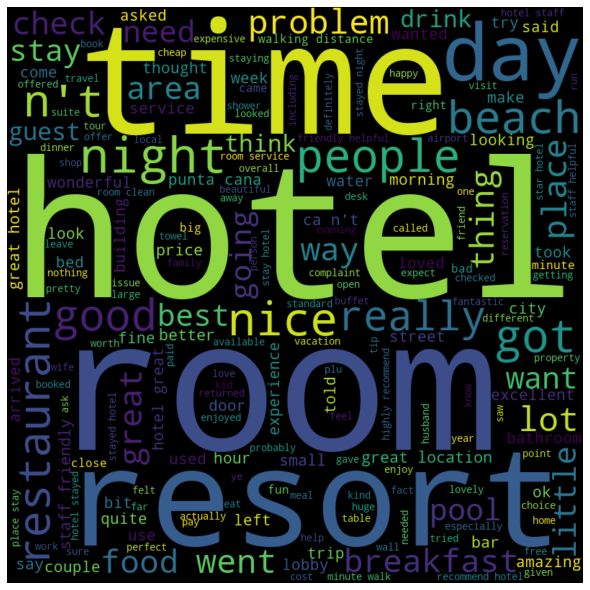

In [13]:
wordCloud_generator(df['Review'])

#### Word count of ratings


In [9]:
df['Review'].value_counts()

nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advantage staying longer, location great walking distance shopping, overall nice experience having pay 40 parking night,                                                                                                                                                                                                                                                                                                                                                                                                                         

In [10]:
df['Word Count'] = df['Review'].apply(lambda x: len(str(x).split(" ")))

In [11]:
df.head()

,Review,Rating,Word Count
0,"nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advantage staying longer, location great walking distance shopping, overall nice experience having pay 40 parking night,",4,89
1,"ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, start booked suite paid extra website description not, suite bedroom bathroom standard hotel room, took printed reservation desk showed said things like tv couch ect desk clerk told oh mixed suites description kimpton website sorry free breakfast, got kidding, embassy suits sitting room bathroom bedroom unlike kimpton calls suite, 5 day stay offer correct false advertising, send kimpton preferred guest website email asking failure provide suite advertised website reservation description furnished hard copy reservation printout website desk manager duty did not reply solution, send email trip guest survey did not follow email mail, guess tell concerned guest.the staff ranged indifferent not helpful, asked desk good breakfast spots neighborhood hood told no hotels, gee best breakfast spots seattle 1/2 block away convenient hotel does not know exist, arrived late night 11 pm inside run bellman busy chating cell phone help bags.prior arrival emailed hotel inform 20th anniversary half really picky wanted make sure good, got nice email saying like deliver bottle champagne chocolate covered strawberries room arrival celebrate, told needed foam pillows, arrival no champagne strawberries no foam pillows great room view alley high rise building good not better housekeeping staff cleaner room property, impressed left morning shopping room got short trips 2 hours, beds comfortable.not good ac-heat control 4 x 4 inch screen bring green shine directly eyes night, light sensitive tape controls.this not 4 start hotel clean business hotel super high rates, better chain hotels seattle,",2,252
2,"nice rooms not 4* experience hotel monaco seattle good hotel n't 4* level.positives large bathroom mediterranean suite comfortable bed pillowsattentive housekeeping staffnegatives ac unit malfunctioned stay desk disorganized, missed 3 separate wakeup calls, concierge busy hard touch, did n't provide guidance special requests.tv hard use ipod sound dock suite non functioning. decided book mediterranean suite 3 night weekend stay 1st choice rest party filled, comparison w spent 45 night larger square footage room great soaking tub whirlpool jets nice shower.before stay hotel arrange car service price 53 tip reasonable driver waiting arrival.checkin easy downside room picked 2 person jacuzi tub no bath accessories salts bubble bath did n't stay, night got 12/1a checked voucher bottle champagne nice gesture fish waiting room, impression room huge open space felt room big, tv far away bed chore change channel, ipod dock broken disappointing.in morning way asked desk check thermostat said 65f 74 2 degrees warm try cover face night bright blue light kept, got room night no, 1st drop desk, called maintainence came look thermostat told play settings happy digital box wo n't work, asked wakeup 10am morning did n't happen, called later 6pm nap wakeup forgot, 10am wakeup morning yep forgotten.the bathroom facilities great room surprised room sold whirlpool bath tub n't bath amenities, great relax water jets going,",3,219
3,"unique, great stay, wonderful time hotel monaco, location excellent short stroll main downtown shopping area, pet friendly room showed no signs animal hair smells, monaco suite sleeping area big striped curtains pulled closed nice touch

<AxesSubplot:xlabel='Rating', ylabel='Word Count'>

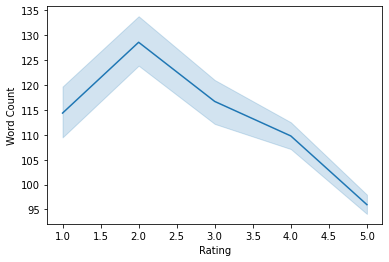

In [12]:
sns.lineplot(x="Rating", y="Word Count", data=df)

### Modelling

In [13]:
df["Rating"].value_counts()


5    9054
4    6039
3    2184
2    1793
1    1421
Name: Rating, dtype: int64

Since there are lots of reviews we can introduce a new column in  which we can take ratings of 4,5 as positive and 1,2,3 as negative. 

In [14]:
df_negative = df.loc[df["Rating"] < 3]
df_negative = df_negative.reset_index(drop=True)

In [15]:
print(len(df_negative))

3214


In [16]:
df_five = df.loc[df["Rating"] == 5]
df_five = df_five.reset_index(drop=True)

In [17]:
print(len(df_five))

9054


In [18]:
df_positive = df_five[:len(df_negative)]


In [19]:
print(len(df_positive))

3214


In [20]:
df_all = pd.concat([df_negative,df_positive],axis=0)


In [21]:
df_all = df_all.reset_index(drop=True)

In [22]:
len(df_all)

6428

In [23]:
df_all.head()

,Review,Rating,Word Count
0,"ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, start booked suite paid extra website description not, suite bedroom bathroom standard hotel room, took printed reservation desk showed said things like tv couch ect desk clerk told oh mixed suites description kimpton website sorry free breakfast, got kidding, embassy suits sitting room bathroom bedroom unlike kimpton calls suite, 5 day stay offer correct false advertising, send kimpton preferred guest website email asking failure provide suite advertised website reservation description furnished hard copy reservation printout website desk manager duty did not reply solution, send email trip guest survey did not follow email mail, guess tell concerned guest.the staff ranged indifferent not helpful, asked desk good breakfast spots neighborhood hood told no hotels, gee best breakfast spots seattle 1/2 block away convenient hotel does not know exist, arrived late night 11 pm inside run bellman busy chating cell phone help bags.prior arrival emailed hotel inform 20th anniversary half really picky wanted make sure good, got nice email saying like deliver bottle champagne chocolate covered strawberries room arrival celebrate, told needed foam pillows, arrival no champagne strawberries no foam pillows great room view alley high rise building good not better housekeeping staff cleaner room property, impressed left morning shopping room got short trips 2 hours, beds comfortable.not good ac-heat control 4 x 4 inch screen bring green shine directly eyes night, light sensitive tape controls.this not 4 start hotel clean business hotel super high rates, better chain hotels seattle,",2,252
1,"poor value stayed monaco seattle july, nice hotel priced 100- 150 night not, hotel takes beating quotient, experience simply average, nothing exceptional paying 300+ n't ca n't terribly disappointed, wife stayed nicest suites 200/night felt like overpaying, best advice shop, quality-wise league average marriott nice best western,",2,49
2,"horrible customer service hotel stay february 3rd 4th 2007my friend picked hotel monaco appealing website online package included champagne late checkout 3 free valet gift spa weekend, friend checked room hours earlier came later, pulled valet young man just stood, asked valet open said, pull bags didn__Ç_é_ offer help, got garment bag suitcase came car key room number says not valet, car park car street pull, left key working asked valet park car gets, went room fine bottle champagne oil lotion gift spa, dressed went came got bed noticed blood drops pillows sheets pillows, disgusted just unbelievable, called desk sent somebody 20 minutes later, swapped sheets left apologizing, sunday morning called desk speak management sheets aggravated rude, apparently no manager kind supervisor weekend wait monday morning, young man spoke said cover food adding person changed sheets said fresh blood rude tone, checkout 3pm package booked, 12 1:30 staff maids tried walk room opening door apologizing closing, people called saying check 12 remind package, finally packed things went downstairs check, quickly signed paper took, way took closer look room, unfortunately covered food offered charged valet, called desk ask charges lady answered snapped saying aware problem experienced monday like told earlier, life treated like hotel, not sure hotel constantly problems lucky ones stay recommend anybody know,",1,216
3,"disappointed say anticipating stay hotel monaco based reviews seen tripadvisor, definitely disppointment, decor room hotel envisioned nice, housekeeping staff impressive extremely polite cheery helpful, desk bellmen standard customer service, lots little things easily overlooked broken make mirror sagging post bathroom jiggly entrance handle room did n't feel secure handle nearly falling door, husband early morning flight mid-week asked cab called, suggested cab ride cost double private car flat-rate n't ca

In [24]:
df_all["Rating"].value_counts()

5    3214
2    1793
1    1421
Name: Rating, dtype: int64

#### Creating a sentiments column

In [25]:
df_all["Sentiment"]  = np.where(df_all["Rating"] == 5, "Positive", "Negative")

In [26]:
df_all.tail()

,Review,Rating,Word Count,Sentiment
6423,"really cozy place enjoyed stay, just came short stay library hotel, picked hotel remembered spent lovely evening roof terrace year ago, reading reviews curious rest hotel.everybody desk helpful friendly did swift check-in, lobby understated minimalist book shelves look booked junior suit special discount price 499 new york substantial money expected lot.i not disappointed, room looked exactly like picture website, lot room wasted room/hallway spacious airy lot windows, nice wooden blinds gave room warm feeling did room colours beige dark wood, small sofa corner armchairs large flat screen tv, bathroom spacious nicely decorated amenities needs.having lived new york knew not going quietest streets mid-town, definitely noisy windows sound-proof.i did not reading room spent time upstairs winter garden course roof terrace, nice rooftop terrace comfortable furniture, benches little stools quite uncomfortable impossible spent leisure afternoon sun major backache, free hotspot available terrace able emails sitting sun not hotels ny offer travellers said great place worth money return,",5,157,Positive
6424,"perfect hotel hotel does not really need glowing review nice add, stayed great attention, room lovely public areas beautiful especially bar 14th floor staff not nicer, petite room reviews n't normal sized double room, suppose does small american room normally queen beds just normal double room, not occurred think room size not described petite room, stayed husband nights fine,",5,61,Positive
6425,"perfect hotel small hotel comfortable perfect location helpful staff good, visit new york come love room no doubt,",5,20,Positive
6426,"ordinary location extraordinary hotel know lovely boutique hotel got positive reviews, stayed based tripadvisor reviews pleased, night stay nov 16 room, small perfect person small suitcase, design dÄcor space furnishings simple elegant line, room didn__Ç_é_ feel cramped small person, room windows good lighting__Ç_ecessary want try interesting books shelf, room bath spotlessly clean, room 11th floor little street noise heard, there__Ç_é_ no room service complimentary food beverages available day long second floor continental breakfast morning coffee tea cookies afternoon wine cheese early evening, hotel staff highly professional friendly helpful address just ask, 41st madison address isn__Ç_é_ trendy nyc areas hotel definitely worth stay, i__Ç_éêl going january reserved room,",5,109,Positive
6427,"classy indulgence awesome experience, staff n't chocolates left day complimentary bottles water, travelling south america just little bit pampering needed perfectly located close, nice end town midtown believe used lingo, food really great, really exceptional cheeses husband said wine pretty great, perfect snacks lunch dinner, just loved place, bought mug remember time, thank staff making ny trip remember, just aware prices upper end ny hotels expensive not classy,",5,70,Positive


#### Randomizing the data


In [27]:
df_all = df_all.sample(frac=1)
df_all = df_all.reset_index(drop=True)

In [28]:
df_all.tail()

Review  Rating  Word Count  \
6423  good location hotel located, rooms quite cozy ...       2          73   
6424  frustrating experience wanted like hotel reall...       2          80   
6425  beautiful hotel husband attended conferece hel...       5          92   
6426  african american sister went punta cana july 2...       2         829   
6427  good times sunscape, stayed sunscape march 22 ...       5          40   

     Sentiment  
6423  Negative  
6424  Negative  
6425  Positive  
6426  Negative  
6427  Positive

### Data preprocessing

In [29]:
df_all.shape

(6428, 4)

In [30]:
df_new = df_all[['Review','Sentiment']]

In [31]:
df_new.head(5)

,Review,Sentiment
0,"lacked quality stayed resort nights beginning february 9-13 2005. originally booked riu taino switched resort days flying norwalk virus riu, teenagers happy large resort accommodations husband felt step service overall satsifaction all-inclusive resorts stayed mexico years, food mediocre, bland, little variety, room dated recently refurbished service poor, used spanish domenicans not nearly friendly helpful mexicans, beach beautiful palm trees, water rough churned, pool water cool, nice vacation nothing rave unfortunately, returned home disappointed probably stay 6-star resorts,",Negative
1,"bed bugs, selected aparthotel acacia based reviews trip advisor, needed room persons aparthotel acacia highest rated hotel slept three.the location residential area not tourist area, metro stop located nearby access barcelona easy, rooms large european standards small refrigerator kitchenette, wi-fi free.but concern involves bed bugs, morning following night noticed bites stomach, years travelling experienced bed bugs thought nothing bites, spent day seeing sites went late dinner, returned night wen change bed clothes realized covered bites torso 90, tired worn day spain no way sleep room 401, called desk told bed bug bites gave room, packed belongings moved 6th floor, just unpacking called told needed room, time got moved settled keys desk 1:30. husband tired frustrated talked desk compensation asked night night stay desk told not authorize sure agreeable.i freaked spent time researching bed bugs internet, news not pleasant, difficult terrible rid, not necessarily caused lack cleanliness actually travel people luggage, hide come hour dawn, transient room room live 18 months feeding typically feed 4-5 nights, needless say did not sleep night stay there.in hindsight moved hotels busy easter weekend finding room persons difficult.the morning went desk spoke day manager, showed photo bites did exist, wanted know took seriously treated room 401 extensively, returned day touring told did not bugs, did not allow animals hotels hotel clean, offered 5 discount 35 euros not believed bed bugs incovenienced twice- ha, joke.i tried contact hotel owner directly ensure aware concerns ask compensation, received no response.my bites did not multiply did continue moe uncomfortable affected pleasure vacation, husband daughter wound bites, continued read bed bugs taking home, bed bugs nasty people actually homes not rid them.upon arrival home forced wash hottest possible water dry 20 minutes, mean sealed sterilized frozen known computers nothing safe bed bugs, possible stop contamination home.but want warn future travellers beware aparthotel acacia, cleanest hotels suffer bed bugs, aparthotel acacia did not situation seriously treat not room 401 entire hotel recommended pest control specialists bed bug infestation continue,",Negative
2,"did n't eat, just returned 2/7/04 week stay, physical property really quite lovely beach beautiful, rooms average slightly average, nice exercise room equipment not operating order.my main comment food, great enclusive drinks, drinks sweet watered food, times day seven days average food terrible food, does hotel domincan republic terrible food, got able look forward end day nice dining experience, fair staff adorable quite helpful friendlythe food terrible not hint left, disappointing, vacation affordable known price going pay food terrible gone.in addition observations staff better versed lanquages, difficult discuss issues them.fixing room problems not handled timely fashion.i interested comments regarding food tr,",Negative
3,"brill visited hotel 23rd june 7th july best hotel visited caribbean, local people staff friendly food acommodation class, reccomend hotel friends hope, alan jewitt,",Positive
4,"big resort wife just returned staying week serenis tropical suites, big resort lots european classify star, just little tired getting early chairs beach, food good service dinner excellent, trip dominican

In [32]:
df_new.shape

(6428, 2)

In [33]:
### stripping html tags
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

### expanding the contractions
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)
#remove the numericals present in the text
def remove_numbers(text):
  text = re.sub(r'\d+', '', text)
  return text
def clean_text(text):
    text = replace_contractions(text)
    text = strip_html_tags(text)
    text = remove_numbers(text)
    return text


In [34]:
#### applying in the dataframe
df_new['Review'] = df_new['Review'].apply(lambda x: clean_text(x))

In [35]:
df_new.head(5)

,Review,Sentiment
0,"lacked quality stayed resort nights beginning february - . originally booked riu taino switched resort days flying norwalk virus riu, teenagers happy large resort accommodations husband felt step service overall satsifaction all-inclusive resorts stayed mexico years, food mediocre, bland, little variety, room dated recently refurbished service poor, used spanish domenicans not nearly friendly helpful mexicans, beach beautiful palm trees, water rough churned, pool water cool, nice vacation nothing rave unfortunately, returned home disappointed probably stay -star resorts,",Negative
1,"bed bugs, selected aparthotel acacia based reviews trip advisor, needed room persons aparthotel acacia highest rated hotel slept three.the location residential area not tourist area, metro stop located nearby access barcelona easy, rooms large european standards small refrigerator kitchenette, wi-fi free.but concern involves bed bugs, morning following night noticed bites stomach, years travelling experienced bed bugs thought nothing bites, spent day seeing sites went late dinner, returned night wen change bed clothes realized covered bites torso , tired worn day spain no way sleep room , called desk told bed bug bites gave room, packed belongings moved th floor, just unpacking called told needed room, time got moved settled keys desk :. husband tired frustrated talked desk compensation asked night night stay desk told not authorize sure agreeable.i freaked spent time researching bed bugs internet, news not pleasant, difficult terrible rid, not necessarily caused lack cleanliness actually travel people luggage, hide come hour dawn, transient room room live months feeding typically feed - nights, needless say did not sleep night stay there.in hindsight moved hotels busy easter weekend finding room persons difficult.the morning went desk spoke day manager, showed photo bites did exist, wanted know took seriously treated room extensively, returned day touring told did not bugs, did not allow animals hotels hotel clean, offered discount euros not believed bed bugs incovenienced twice- ha, joke.i tried contact hotel owner directly ensure aware concerns ask compensation, received no response.my bites did not multiply did continue moe uncomfortable affected pleasure vacation, husband daughter wound bites, continued read bed bugs taking home, bed bugs nasty people actually homes not rid them.upon arrival home forced wash hottest possible water dry minutes, mean sealed sterilized frozen known computers nothing safe bed bugs, possible stop contamination home.but want warn future travellers beware aparthotel acacia, cleanest hotels suffer bed bugs, aparthotel acacia did not situation seriously treat not room entire hotel recommended pest control specialists bed bug infestation continue,",Negative
2,"did n't eat, just returned // week stay, physical property really quite lovely beach beautiful, rooms average slightly average, nice exercise room equipment not operating order.my main comment food, great enclusive drinks, drinks sweet watered food, times day seven days average food terrible food, does hotel domincan republic terrible food, got able look forward end day nice dining experience, fair staff adorable quite helpful friendlythe food terrible not hint left, disappointing, vacation affordable known price going pay food terrible gone.in addition observations staff better versed lanquages, difficult discuss issues them.fixing room problems not handled timely fashion.i interested comments regarding food tr,",Negative
3,"brill visited hotel rd june th july best hotel visited caribbean, local people staff friendly food acommodation class, reccomend hotel friends hope, alan jewitt,",Positive
4,"big resort wife just returned staying week serenis tropical suites, big resort lots european classify star, just little tired getting early chairs beach, food good service dinner excellent, trip dominican republic lots caribbean discover,",Negative


#### Tokenizing the reviews


In [36]:
df_new['Review'] = df_new.apply(lambda x: nltk.word_tokenize(x['Review']), axis=1)

In [37]:
df_new.head(5)

,Review,Sentiment
0,"[lacked, quality, stayed, resort, nights, beginning, february, -, ., originally, booked, riu, taino, switched, resort, days, flying, norwalk, virus, riu, ,, teenagers, happy, large, resort, accommodations, husband, felt, step, service, overall, satsifaction, all-inclusive, resorts, stayed, mexico, years, ,, food, mediocre, ,, bland, ,, little, variety, ,, room, dated, recently, refurbished, service, poor, ,, used, spanish, domenicans, not, nearly, friendly, helpful, mexicans, ,, beach, beautiful, palm, trees, ,, water, rough, churned, ,, pool, water, cool, ,, nice, vacation, nothing, rave, unfortunately, ,, returned, home, disappointed, probably, stay, -star, resorts, ,]",Negative
1,"[bed, bugs, ,, selected, aparthotel, acacia, based, reviews, trip, advisor, ,, needed, room, persons, aparthotel, acacia, highest, rated, hotel, slept, three.the, location, residential, area, not, tourist, area, ,, metro, stop, located, nearby, access, barcelona, easy, ,, rooms, large, european, standards, small, refrigerator, kitchenette, ,, wi-fi, free.but, concern, involves, bed, bugs, ,, morning, following, night, noticed, bites, stomach, ,, years, travelling, experienced, bed, bugs, thought, nothing, bites, ,, spent, day, seeing, sites, went, late, dinner, ,, returned, night, wen, change, bed, clothes, realized, covered, bites, torso, ,, tired, worn, day, spain, no, way, sleep, room, ,, called, desk, told, bed, bug, ...]",Negative
2,"[did, n't, eat, ,, just, returned, //, week, stay, ,, physical, property, really, quite, lovely, beach, beautiful, ,, rooms, average, slightly, average, ,, nice, exercise, room, equipment, not, operating, order.my, main, comment, food, ,, great, enclusive, drinks, ,, drinks, sweet, watered, food, ,, times, day, seven, days, average, food, terrible, food, ,, does, hotel, domincan, republic, terrible, food, ,, got, able, look, forward, end, day, nice, dining, experience, ,, fair, staff, adorable, quite, helpful, friendlythe, food, terrible, not, hint, left, ,, disappointing, ,, vacation, affordable, known, price, going, pay, food, terrible, gone.in, addition, observations, staff, better, versed, lanquages, ,, difficult, ...]",Negative
3,"[brill, visited, hotel, rd, june, th, july, best, hotel, visited, caribbean, ,, local, people, staff, friendly, food, acommodation, class, ,, reccomend, hotel, friends, hope, ,, alan, jewitt, ,]",Positive
4,"[big, resort, wife, just, returned, staying, week, serenis, tropical, suites, ,, big, resort, lots, european, classify, star, ,, just, little, tired, getting, early, chairs, beach, ,, food, good, service, dinner, excellent, ,, trip, dominican, republic, lots, caribbean, discover, ,]",Negative


#### Removing stop words and lemmatization

In [40]:
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

### removing the non ascii characters
def remove_non_ascii(words):
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

### converting all the words to lower case
def to_lowercase(words):
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

### removing the punctuations
def remove_punctuation(words):
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

#### removing the stopwords
def remove_stopwords(words):
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

# lemmatize the words
def lemmatize_list(words):
    new_words = []
    for word in words:
      new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words

def stop_lemma(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = lemmatize_list(words)
    return ' '.join (words)





In [41]:
df_new['Review'] = df_new.apply(lambda x: stop_lemma(x['Review']),axis=1)

In [42]:
df_new.head(5)

,Review,Sentiment
0,lack quality stay resort nights begin february originally book riu taino switch resort days fly norwalk virus riu teenagers happy large resort accommodations husband felt step service overall satsifaction allinclusive resort stay mexico years food mediocre bland little variety room date recently refurbish service poor use spanish domenicans nearly friendly helpful mexicans beach beautiful palm tree water rough churn pool water cool nice vacation nothing rave unfortunately return home disappoint probably stay star resort,Negative
1,bed bug select aparthotel acacia base review trip advisor need room persons aparthotel acacia highest rat hotel sleep threethe location residential area tourist area metro stop locate nearby access barcelona easy room large european standards small refrigerator kitchenette wifi freebut concern involve bed bug morning follow night notice bite stomach years travel experience bed bug think nothing bite spend day see sit go late dinner return night wen change bed clothe realize cover bite torso tire wear day spain way sleep room call desk tell bed bug bite give room pack belong move th floor unpack call tell need room time get move settle key desk husband tire frustrate talk desk compensation ask night night stay desk tell authorize sure agreeablei freak spend time research bed bug internet news pleasant difficult terrible rid necessarily cause lack cleanliness actually travel people luggage hide come hour dawn transient room room live months feed typically fee nights needle say sleep night stay therein hindsight move hotels busy easter weekend find room persons difficultthe morning go desk speak day manager show photo bite exist want know take seriously treat room extensively return day tour tell bug allow animals hotels hotel clean offer discount euros believe bed bug incovenienced twice ha jokei try contact hotel owner directly ensure aware concern ask compensation receive responsemy bite multiply continue moe uncomfortable affect pleasure vacation husband daughter wind bite continue read bed bug take home bed bug nasty people actually home rid themupon arrival home force wash hottest possible water dry minutes mean seal sterilize freeze know computers nothing safe bed bug possible stop contamination homebut want warn future travellers beware aparthotel acacia cleanest hotels suffer bed bug aparthotel acacia situation seriously treat room entire hotel recommend pest control specialists bed bug infestation continue,Negative
2,nt eat return week stay physical property really quite lovely beach beautiful room average slightly average nice exercise room equipment operate ordermy main comment food great enclusive drink drink sweet water food time day seven days average food terrible food hotel domincan republic terrible food get able look forward end day nice din experience fair staff adorable quite helpful friendlythe food terrible hint leave disappoint vacation affordable know price go pay food terrible gonein addition observations staff better verse lanquages difficult discuss issue themfixing room problems handle timely fashioni interest comment regard food tr,Negative
3,brill visit hotel rd june th july best hotel visit caribbean local people staff friendly food acommodation class reccomend hotel friends hope alan jewitt,Positive
4,big resort wife return stay week serenis tropical suit big resort lot european classify star little tire get early chair beach food good service dinner excellent trip dominican republic lot caribbean discover,Negative


The above data has been cleaned and preprocessed and we can now start building our model.

#### Preparing model using CountVectorizer and Tfidf

In [43]:
replaceStruct = {
                "Sentiment": {"Positive": 1, "Negative": 0}
                }

In [44]:
df_new = df_new.replace(replaceStruct)

In [45]:
df_new.head(5)

,Review,Sentiment
0,lack quality stay resort nights begin february originally book riu taino switch resort days fly norwalk virus riu teenagers happy large resort accommodations husband felt step service overall satsifaction allinclusive resort stay mexico years food mediocre bland little variety room date recently refurbish service poor use spanish domenicans nearly friendly helpful mexicans beach beautiful palm tree water rough churn pool water cool nice vacation nothing rave unfortunately return home disappoint probably stay star resort,0
1,bed bug select aparthotel acacia base review trip advisor need room persons aparthotel acacia highest rat hotel sleep threethe location residential area tourist area metro stop locate nearby access barcelona easy room large european standards small refrigerator kitchenette wifi freebut concern involve bed bug morning follow night notice bite stomach years travel experience bed bug think nothing bite spend day see sit go late dinner return night wen change bed clothe realize cover bite torso tire wear day spain way sleep room call desk tell bed bug bite give room pack belong move th floor unpack call tell need room time get move settle key desk husband tire frustrate talk desk compensation ask night night stay desk tell authorize sure agreeablei freak spend time research bed bug internet news pleasant difficult terrible rid necessarily cause lack cleanliness actually travel people luggage hide come hour dawn transient room room live months feed typically fee nights needle say sleep night stay therein hindsight move hotels busy easter weekend find room persons difficultthe morning go desk speak day manager show photo bite exist want know take seriously treat room extensively return day tour tell bug allow animals hotels hotel clean offer discount euros believe bed bug incovenienced twice ha jokei try contact hotel owner directly ensure aware concern ask compensation receive responsemy bite multiply continue moe uncomfortable affect pleasure vacation husband daughter wind bite continue read bed bug take home bed bug nasty people actually home rid themupon arrival home force wash hottest possible water dry minutes mean seal sterilize freeze know computers nothing safe bed bug possible stop contamination homebut want warn future travellers beware aparthotel acacia cleanest hotels suffer bed bug aparthotel acacia situation seriously treat room entire hotel recommend pest control specialists bed bug infestation continue,0
2,nt eat return week stay physical property really quite lovely beach beautiful room average slightly average nice exercise room equipment operate ordermy main comment food great enclusive drink drink sweet water food time day seven days average food terrible food hotel domincan republic terrible food get able look forward end day nice din experience fair staff adorable quite helpful friendlythe food terrible hint leave disappoint vacation affordable know price go pay food terrible gonein addition observations staff better verse lanquages difficult discuss issue themfixing room problems handle timely fashioni interest comment regard food tr,0
3,brill visit hotel rd june th july best hotel visit caribbean local people staff friendly food acommodation class reccomend hotel friends hope alan jewitt,1
4,big resort wife return stay week serenis tropical suit big resort lot european classify star little tire get early chair beach food good service dinner excellent trip dominican republic lot caribbean discover,0


In [46]:
df_new["Sentiment"].value_counts()

0    3214
1    3214
Name: Sentiment, dtype: int64

<AxesSubplot:>

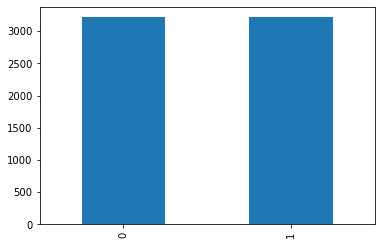

In [47]:
df_new["Sentiment"].value_counts().plot(kind='bar')

There is a class balance present in the data.

### CountVectorizer

In [48]:
from sklearn.feature_extraction.text import CountVectorizer

In [49]:
count_vect = CountVectorizer(max_features=500)
data_features = count_vect.fit_transform(df_new['Review'])
data_features = data_features.toarray()


In [50]:
data_features.shape


(6428, 500)

In [54]:
print(count_vect.get_feature_names())

['able', 'absolutely', 'ac', 'access', 'activities', 'actually', 'add', 'afternoon', 'air', 'airport', 'allow', 'amaze', 'american', 'appear', 'area', 'areas', 'arrival', 'arrive', 'ask', 'available', 'average', 'avoid', 'away', 'awesome', 'bad', 'bag', 'balcony', 'bar', 'base', 'bath', 'bathroom', 'bathrooms', 'bavaro', 'beach', 'beautiful', 'bed', 'believe', 'best', 'better', 'big', 'bite', 'block', 'boat', 'book', 'bother', 'bottle', 'break', 'breakfast', 'bring', 'buffet', 'bug', 'build', 'bus', 'business', 'busy', 'buy', 'ca', 'call', 'cana', 'car', 'card', 'care', 'carpet', 'casino', 'center', 'central', 'certainly', 'chair', 'change', 'charge', 'charm', 'cheap', 'check', 'checkin', 'cheese', 'children', 'choice', 'choose', 'city', 'clean', 'close', 'club', 'coffee', 'cold', 'come', 'comfortable', 'comment', 'complain', 'completely', 'complimentary', 'concierge', 'condition', 'consider', 'convenient', 'cool', 'corner', 'cost', 'country', 'couple', 'course', 'credit', 'crowd', 'cu

In [55]:
print(data_features)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 1 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]]


In [51]:
X = data_features
y = df_new['Sentiment']

In [52]:
print(X.shape)
print(y.shape)


(6428, 500)
(6428,)


In [53]:
### splitting the data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0,shuffle=False)

In [54]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(5142, 500)
(1286, 500)
(5142,)
(1286,)


In [55]:
# Finding optimal number of base learners using k-fold CV ->
base_ln = np.arange(100,400,100).tolist()
base_ln

[100, 200, 300]

In [56]:
# K-Fold Cross - validation .
cv_scores = []
for b in base_ln:
    clf = RandomForestClassifier(n_estimators = b)
    print(type(clf))
    scores = cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'accuracy')
    print(scores)
    cv_scores.append(scores.mean())
cv_scores

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
[0.91059281 0.91739553 0.91050584 0.92023346 0.90564202]
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
[0.9154519  0.90864917 0.91731518 0.91828794 0.91439689]
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
[0.92225462 0.90864917 0.92217899 0.92120623 0.90953307]


[0.9128739322299235, 0.9148202137998057, 0.9167644156050413]

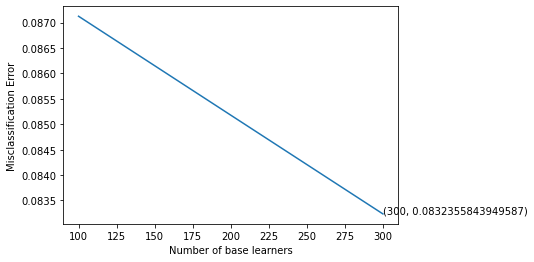

In [57]:
# plotting the error as k increases
error = [1 - x for x in cv_scores]                                 #error corresponds to each nu of estimator
optimal_learners = base_ln[error.index(min(error))]                #Selection of optimal nu of n_estimator corresponds to minimum error.
plt.plot(base_ln, error)                                           #Plot between each nu of estimator and misclassification error
xy = (optimal_learners, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

In [58]:
# Training the best model and calculating accuracy on test data .
clf = RandomForestClassifier(n_estimators = optimal_learners)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)
count_vectorizer_predicted = clf.predict(X_test)
print(classification_report(y_test ,count_vectorizer_predicted , target_names = ['1' , '0']))
print("Accuracy of the model is : ",accuracy_score(y_test,count_vectorizer_predicted))

              precision    recall  f1-score   support

           1       0.93      0.92      0.92       667
           0       0.91      0.92      0.92       619

    accuracy                           0.92      1286
   macro avg       0.92      0.92      0.92      1286
weighted avg       0.92      0.92      0.92      1286

Accuracy of the model is :  0.9191290824261276


great,wonderful,love,excellent,tell,room,perfect,friendly,dirty,worst,comfortable,pay,helpful,fantastic,rude,bad,terrible,ok,poor,best,location,staff,charge,smell,highly,horrible,wall,hotel,nt,recommend,enjoy,star,stay,quiet,ask,amaze,disappoint,say,spacious,tiny,
 
 


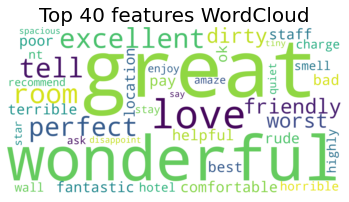

In [59]:
all_features = count_vect.get_feature_names()              #Instantiate the feature from the vectorizer
top_features=''                                            # Addition of top 40 feature into top_feature after training the model
feat=clf.feature_importances_
features=np.argsort(feat)[::-1]
for i in features[0:40]:
    top_features+=all_features[i]
    top_features+=','
    
print(top_features)  

print(" ") 
print(" ")     

from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white",colormap='viridis',width=2000, 
                          height=1000).generate(top_features)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.figure(1, figsize=(14, 11), frameon='equal')
plt.title('Top 40 features WordCloud', fontsize=20)
plt.axis("off")
plt.show()

#### TfIdf vectorizer


In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [61]:
tfidf_vect = TfidfVectorizer(max_features=1000) ###change the maximun number of features
data_features = tfidf_vect.fit_transform(df_new['Review'])
data_features = data_features.toarray()
data_features.shape

(6428, 1000)

In [67]:
print(tfidf_vect.get_feature_names())

['able', 'absolutely', 'ac', 'access', 'accommodate', 'activities', 'actually', 'add', 'additional', 'adequate', 'adults', 'advance', 'advantage', 'advertise', 'advice', 'advise', 'advisor', 'afternoon', 'age', 'agent', 'ago', 'agree', 'air', 'airport', 'allinclusive', 'allow', 'alot', 'amaze', 'amenities', 'american', 'americans', 'amsterdam', 'anniversary', 'annoy', 'answer', 'apparently', 'appear', 'apple', 'appoint', 'appreciate', 'april', 'area', 'areas', 'arrange', 'arrival', 'arrive', 'ask', 'atmosphere', 'attempt', 'attention', 'attentive', 'attitude', 'attractions', 'august', 'available', 'average', 'avoid', 'aware', 'away', 'awesome', 'awful', 'bad', 'bag', 'balcony', 'bambu', 'bar', 'barcelona', 'barely', 'bartenders', 'base', 'basic', 'basically', 'bath', 'bathroom', 'bathrooms', 'bavaro', 'beach', 'beat', 'beautiful', 'bed', 'bedroom', 'beer', 'begin', 'believe', 'bell', 'best', 'better', 'beware', 'big', 'biggest', 'bill', 'birthday', 'bite', 'black', 'block', 'blow', 'bl

In [68]:
print(data_features)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.1266066  0.         ... 0.         0.         0.15774523]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [62]:
X = data_features
y = df_new['Sentiment']


In [63]:
### splitting the data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0,shuffle=False)

In [64]:
print("X_train size:",X_train.shape)
print("X_test size:",X_test.shape)
print("y_train size:",y_train.shape)
print("y_test size:",y_test.shape)


X_train size: (5142, 1000)
X_test size: (1286, 1000)
y_train size: (5142,)
y_test size: (1286,)


In [65]:
# Finding optimal number of base learners using k-fold CV ->
base_ln = np.arange(100,400,100).tolist()
base_ln

[100, 200, 300]

In [66]:
# K-Fold Cross - validation .
cv_scores = []
for b in base_ln:
    clf = RandomForestClassifier(n_estimators = b)
    scores = cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'accuracy')
    print(scores)
    cv_scores.append(scores.mean())
cv_scores

[0.9271137  0.92614189 0.93287938 0.92607004 0.91828794]
[0.93294461 0.92419825 0.9270428  0.92898833 0.91536965]
[0.93100097 0.93100097 0.92996109 0.93093385 0.9192607 ]


[0.9260985884070138, 0.9257087270705948, 0.9284315171315887]

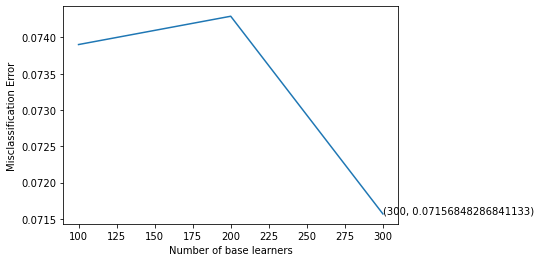

In [67]:
# plotting the error as k increases
error = [1 - x for x in cv_scores]                                 #error corresponds to each nu of estimator
optimal_learners = base_ln[error.index(min(error))]                #Selection of optimal nu of n_estimator corresponds to minimum error.
plt.plot(base_ln, error)                                           #Plot between each nu of estimator and misclassification error
xy = (optimal_learners, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

## Random Forest without hyperparameter tuning


In [68]:
# Training the best model and calculating accuracy on test data .
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)
tf_idf_predicted = clf.predict(X_test)
print(classification_report(y_test , tf_idf_predicted , target_names = ['0' , '1']))
print("Accuracy of the model is : ",accuracy_score(y_test,tf_idf_predicted))

              precision    recall  f1-score   support

           0       0.94      0.91      0.92       667
           1       0.91      0.94      0.92       619

    accuracy                           0.92      1286
   macro avg       0.92      0.92      0.92      1286
weighted avg       0.92      0.92      0.92      1286

Accuracy of the model is :  0.9222395023328149


[[607  60]
 [ 40 579]]


<AxesSubplot:>

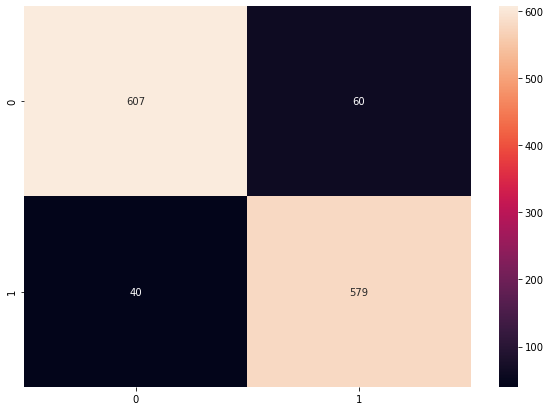

In [69]:

conf_mat = confusion_matrix(y_test, tf_idf_predicted)

print(conf_mat)

df_cm = pd.DataFrame(conf_mat, index = [i for i in ['0', '1']],
                  columns = [i for i in ['0', '1']])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

great, love, wonderful, excellent, tell, room, perfect, friendly, comfortable, dirty, worst, helpful, fantastic, rude, bad, pay, poor, best, staff, highly, terrible, ok, location, smell, enjoy, charge, recommend, horrible, star, stay, spacious, ask, wall, walk, quiet, nt, square, amaze, finally, fabulous, 
 
 


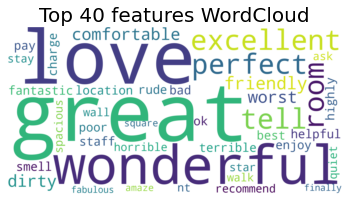

In [70]:
all_features = tfidf_vect.get_feature_names()              #Instantiate the feature from the vectorizer
top_features=''                                            # Addition of top 40 feature into top_feature after training the model
feat=clf.feature_importances_
features=np.argsort(feat)[::-1]
for i in features[0:40]:
    top_features+=all_features[i]
    top_features+=', '
    
print(top_features)  

print(" ") 
print(" ") 

from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white",colormap='viridis',width=2000, 
                          height=1000).generate(top_features)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.figure(1, figsize=(14, 11), frameon='equal')
plt.title('Top 40 features WordCloud', fontsize=20)
plt.axis("off")
plt.show()

In [71]:
#convert the test samples into a dataframe where the columns are
#the y_test(ground truth labels),tf-idf model predicted labels(tf_idf_predicted),Count Vectorizer model predicted labels(count_vectorizer_predicted)
df = pd.DataFrame(y_test.tolist(),columns =['y_test'])
df['count_vectorizer_predicted'] = count_vectorizer_predicted
df['tf_idf_predicted'] = tf_idf_predicted
df.head()

,y_test,count_vectorizer_predicted,tf_idf_predicted
0,1,0,1
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


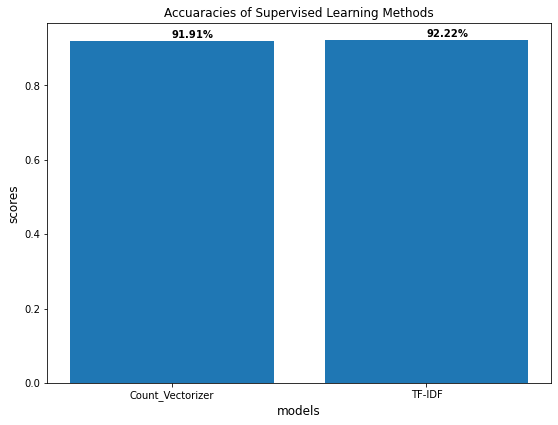

In [72]:
#create bar plot to compare the accuaracies of Count Vectorizer and TF-IDF
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(7,5))
ax = fig.add_axes([0,0,1,1])
subjects = ['Count_Vectorizer', 'TF-IDF']

# calculation accuracies of Count Vectorizer and TF-IDF using accuracy_score metrics
scores = [accuracy_score(y_test,count_vectorizer_predicted),accuracy_score(y_test,tf_idf_predicted)]
ax.bar(subjects,scores)
ax.set_ylabel('scores',fontsize= 12)    # y axis label
ax.set_xlabel('models',fontsize= 12)    # x axis label
ax.set_title('Accuaracies of Supervised Learning Methods')  # tittle
for i, v in enumerate(scores):
    ax.text( i ,v+0.01, '{:.2f}%'.format(100*v), color='black', fontweight='bold')     
    plt.savefig('barplot_1.png',dpi=100, format='png', bbox_inches='tight')
plt.show()

TFIDF performs slightly better than CountVectorizer

SO we will use TFIDF vectorizer for our model

## Modeling

In [73]:
tfidf_vect = TfidfVectorizer(max_features=1000) ###change the maximun number of features
data_features1 = tfidf_vect.fit_transform(df_new['Review'])
data_features1 = data_features1.toarray()
data_features1.shape

(6428, 1000)

In [74]:
X1 = data_features1
y1 = df_new['Sentiment']

In [75]:
### splitting the data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=0,shuffle=False)

In [76]:
print("X_train size:",X_train.shape)
print("X_test size:",X_test.shape)
print("y_train size:",y_train.shape)
print("y_test size:",y_test.shape)


X_train size: (5142, 1000)
X_test size: (1286, 1000)
y_train size: (5142,)
y_test size: (1286,)


In [84]:
# #### GridSearchCV for RandomForestClassifier
# from sklearn.model_selection import GridSearchCV


In [85]:
# clf = RandomForestClassifier()
# param_grid = { 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
#                 'max_features': ['auto', 'sqrt', 'log2'],
#                 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
#                 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
#                 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
#                 'bootstrap': [True, False],
#                 'criterion': ['gini', 'entropy']}
# grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
# grid_search.fit(X_train, y_train)



In [86]:
# df_results = pd.DataFrame(grid_search.cv_results_)

### Naive Bayes


In [77]:
#### naive bayes classifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score


In [78]:
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

### Gaussian Naive Bayes

In [79]:
gnb.fit(X_train,y_train)
y_pred1 = gnb.predict(X_test)
print("Accuracy Score: ", accuracy_score(y_test,y_pred1))
print("Confusion Matrix: ",'\n' ,confusion_matrix(y_test,y_pred1))
print("Precision score: ",precision_score(y_test,y_pred1))
print("Classification Report: ",'\n' ,classification_report(y_test,y_pred1))

Accuracy Score:  0.9175738724727839
Confusion Matrix:  
 [[613  54]
 [ 52 567]]
Precision score:  0.9130434782608695
Classification Report:  
               precision    recall  f1-score   support

           0       0.92      0.92      0.92       667
           1       0.91      0.92      0.91       619

    accuracy                           0.92      1286
   macro avg       0.92      0.92      0.92      1286
weighted avg       0.92      0.92      0.92      1286



<AxesSubplot:>

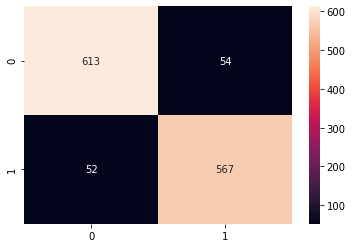

In [80]:
sns.heatmap(confusion_matrix(y_test,y_pred1),annot=True,fmt='g')

### Multinomial Naive Bayes

In [85]:
mnb.fit(X_train,y_train)
y_pred1 = mnb.predict(X_test)
print("Accuracy Score: ", accuracy_score(y_test,y_pred1))
print("Confusion Matrix: ",'\n' ,confusion_matrix(y_test,y_pred1))
print("Precision score: ",precision_score(y_test,y_pred1))
print("Classification Report: ",'\n' ,classification_report(y_test,y_pred1))

Accuracy Score:  0.9416796267496111
Confusion Matrix:  
 [[619  48]
 [ 27 592]]
Precision score:  0.925
Classification Report:  
               precision    recall  f1-score   support

           0       0.96      0.93      0.94       667
           1       0.93      0.96      0.94       619

    accuracy                           0.94      1286
   macro avg       0.94      0.94      0.94      1286
weighted avg       0.94      0.94      0.94      1286



<AxesSubplot:>

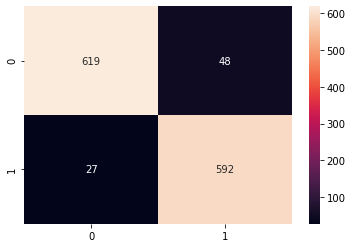

In [86]:
sns.heatmap(confusion_matrix(y_test,y_pred1),annot=True,fmt='g')

### Bernoulli Naive Bayes

In [87]:
bnb.fit(X_train,y_train)
y_pred1 = bnb.predict(X_test)
print("Accuracy Score: ", accuracy_score(y_test,y_pred1))
print("Confusion Matrix: ",'\n' ,confusion_matrix(y_test,y_pred1))
print("Precision score: ",precision_score(y_test,y_pred1))
print("Classification Report: ",'\n' ,classification_report(y_test,y_pred1))

Accuracy Score:  0.8740279937791602
Confusion Matrix:  
 [[559 108]
 [ 54 565]]
Precision score:  0.8395245170876672
Classification Report:  
               precision    recall  f1-score   support

           0       0.91      0.84      0.87       667
           1       0.84      0.91      0.87       619

    accuracy                           0.87      1286
   macro avg       0.88      0.88      0.87      1286
weighted avg       0.88      0.87      0.87      1286



<AxesSubplot:>

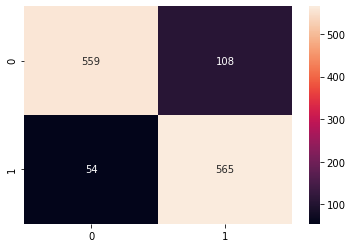

In [89]:
sns.heatmap(confusion_matrix(y_test,y_pred1),annot=True,fmt='g')


SO Tfidf with Multinomial Naive Bayes performs better than the other models

#### Implementing other models

In [90]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

In [91]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=40)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)


In [92]:
clfs = {
    'Support Vector Machine' : svc,
    'K- Nearest Neighbors' : knc, 
    'Multinomial Naive Bayes': mnb, 
    'Decision Tree': dtc, 
    'Logistic Regression': lrc, 
    'Random Forest': rfc, 
    'AdaBoost': abc, 
   
}

In [93]:
def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    return accuracy,precision

In [94]:
train_classifier(svc,X_train,y_train,X_test,y_test)


(0.9517884914463453, 0.9470304975922953)

In [95]:
accuracy_scores = []
precision_scores = []

for name,clf in clfs.items():
    
    current_accuracy,current_precision = train_classifier(clf, X_train,y_train,X_test,y_test)
    
    print("For ",name)
    print("Accuracy - ",current_accuracy)
    print("Precision - ",current_precision)
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

For  Support Vector Machine
Accuracy -  0.9517884914463453
Precision -  0.9470304975922953
For  K- Nearest Neighbors
Accuracy -  0.8709175738724728
Precision -  0.8258992805755395
For  Multinomial Naive Bayes
Accuracy -  0.9416796267496111
Precision -  0.925
For  Decision Tree
Accuracy -  0.8164852255054432
Precision -  0.8123980424143556
For  Logistic Regression
Accuracy -  0.9471228615863142
Precision -  0.942215088282504
For  Random Forest
Accuracy -  0.9175738724727839
Precision -  0.902668759811617
For  AdaBoost
Accuracy -  0.9004665629860031
Precision -  0.895330112721417


In [96]:
performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores}).sort_values('Precision',ascending=False)


In [97]:
performance_df


,Algorithm,Accuracy,Precision
0,Support Vector Machine,0.951788,0.947030
4,Logistic Regression,0.947123,0.942215
2,Multinomial Naive Bayes,0.941680,0.925000
5,Random Forest,0.917574,0.902669
6,AdaBoost,0.900467,0.895330
1,K- Nearest Neighbors,0.870918,0.825899
3,Decision Tree,0.816485,0.812398


SVM performs better than the other models


# -----------------------------------------------------------------------------------------------------------------------------------------------------

### Hyper parameter tuning SVM

In [98]:
from sklearn.svm import SVC

### Hyper parameter tuning SVM using GridSearchCV


In [104]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


clf = GridSearchCV(SVC(gamma='auto'), {
    'C': [1,10,20],
    'kernel': ['rbf','linear','sigmoid']
}, cv=5, return_train_score=False)
clf.fit(X_train, y_train)
clf.cv_results_


{'mean_fit_time': array([10.5412672 ,  3.38938184, 10.21179147,  2.22003064,  8.34570074,
         2.31535225]),
 'std_fit_time': array([0.46343135, 0.30380377, 0.40687311, 0.11182805, 0.35348382,
        0.11046146]),
 'mean_score_time': array([3.81031222, 0.53534441, 3.46540856, 0.22241735, 2.82206979,
        0.26844082]),
 'std_score_time': array([0.13737668, 0.07594881, 0.13519715, 0.02204681, 0.08452226,
        0.05857047]),
 'param_C': masked_array(data=[1, 1, 10, 10, 20, 20],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_kernel': masked_array(data=['rbf', 'linear', 'rbf', 'linear', 'rbf', 'linear'],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 1, 'kernel': 'rbf'},
  {'C': 1, 'kernel': 'linear'},
  {'C': 10, 'kernel': 'rbf'},
  {'C': 10, 'kernel': 'linear'},
  {'C': 20, 'kernel': 'rbf'},
  {'C': 20, 'kernel': 'linea

In [109]:
clf.best_params_

{'C': 1, 'kernel': 'linear'}

In [110]:

clf.best_score_

0.9517696906444624

In [111]:
print("Classification Report: ",'\n' ,classification_report(y_test,y_pred1))

Classification Report:  
               precision    recall  f1-score   support

           0       0.91      0.84      0.87       667
           1       0.84      0.91      0.87       619

    accuracy                           0.87      1286
   macro avg       0.88      0.88      0.87      1286
weighted avg       0.88      0.87      0.87      1286



In [148]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto'),
        'params' : {
            'C': [1,10,20,30,40,50],
            'kernel': ['rbf','linear','sigmoid']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [1,5,10,20,30]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'C': [1,5,10,20,30]
        }
    }
}

In [149]:
scores = []

for model_name, mp in model_params.items():
    clf_all =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf_all.fit(X_train, y_train)
    scores.append({
        'model': model_name,
        'best_score': clf_all.best_score_,
        'best_params': clf_all.best_params_
    })
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.951770,"{'C': 1, 'kernel': 'linear'}"
1,random_forest,0.908401,{'n_estimators': 30}
2,logistic_regression,0.951770,{'C': 5}


In [ ]:
# tfidf_vect1 = TfidfVectorizer(max_features=1000) ###change the maximun number of features
# data_features = tfidf_vect.fit_transform(df_new['Review'])
# data_features = data_features.toarray()
# data_features.shape

In [235]:
lrc_1 = LogisticRegression(solver='liblinear', penalty='l1')
lrc_1.fit(X_train,y_train)
y_pred = lrc_1.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)


In [236]:
print("Accuracy Score: ", accuracy)

Accuracy Score:  0.9393468118195957


In [120]:
## hyperparameter tuning for logistic regression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

lr_hype = GridSearchCV(LogisticRegression(solver='liblinear', multi_class='auto'), {
    'C': [1,5,10,20,30]
}, cv=5, return_train_score=False)
lr_hype.fit(X_train, y_train)
lr_hype.cv_results_


{'mean_fit_time': array([0.06219459, 0.0512754 , 0.05444798, 0.0605617 , 0.06124315]),
 'std_fit_time': array([0.02814253, 0.00176168, 0.00423742, 0.00257498, 0.00234308]),
 'mean_score_time': array([0.00422382, 0.00158114, 0.00131865, 0.00128303, 0.00152879]),
 'std_score_time': array([5.66512272e-03, 5.35742652e-04, 1.34519844e-04, 9.25488719e-05,
        2.54800085e-04]),
 'param_C': masked_array(data=[1, 5, 10, 20, 30],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 1}, {'C': 5}, {'C': 10}, {'C': 20}, {'C': 30}],
 'split0_test_score': array([0.94655005, 0.95043732, 0.94557823, 0.9436346 , 0.9436346 ]),
 'split1_test_score': array([0.94752187, 0.95238095, 0.95238095, 0.95238095, 0.95238095]),
 'split2_test_score': array([0.95136187, 0.95233463, 0.95233463, 0.94552529, 0.94844358]),
 'split3_test_score': array([0.95136187, 0.95525292, 0.95817121, 0.95233463, 0.94649805]),
 'split4_test_score': array([0.944

In [121]:
lr_hype.best_params_

{'C': 5}

In [122]:
lr_hype.best_score_

0.9517698797139756

#### hyper paratmeter tuning for multinomial naive bayes



In [134]:
SVC().get_params().keys()

dict_keys(['C', 'break_ties', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose'])

In [130]:
MultinomialNB().get_params().keys()

dict_keys(['alpha', 'class_prior', 'fit_prior'])

In [129]:

mnb_hype = GridSearchCV(MultinomialNB(), {
    'alpha': [1,5,10,20,30]
}, cv=5, return_train_score=False)
mnb_hype.fit(X_train, y_train)
mnb_hype.cv_results_

{'mean_fit_time': array([0.05656548, 0.01757817, 0.01697364, 0.01763864, 0.01761594]),
 'std_fit_time': array([0.05911272, 0.00085604, 0.00066371, 0.00142246, 0.00120231]),
 'mean_score_time': array([0.00430689, 0.00200934, 0.00186572, 0.00189533, 0.00238285]),
 'std_score_time': array([0.00331633, 0.00030234, 0.00012267, 0.00023081, 0.00024882]),
 'param_alpha': masked_array(data=[1, 5, 10, 20, 30],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 1},
  {'alpha': 5},
  {'alpha': 10},
  {'alpha': 20},
  {'alpha': 30}],
 'split0_test_score': array([0.93877551, 0.93100097, 0.92419825, 0.92031098, 0.91836735]),
 'split1_test_score': array([0.94849368, 0.9494655 , 0.94266278, 0.93780369, 0.93197279]),
 'split2_test_score': array([0.94649805, 0.94357977, 0.93968872, 0.93385214, 0.93093385]),
 'split3_test_score': array([0.94844358, 0.94844358, 0.942607  , 0.94163424, 0.93579767]),
 'split4_test_score': array([0

In [131]:
mnb_hype.best_params_

{'alpha': 1}

In [132]:
mnb_hype.best_score_

0.9439908036588733

## Trying ensemble models with the best parameters

In [166]:
# Voting Classifier
svc = SVC(kernel='linear', C = 1,probability=True)
lr = LogisticRegression(solver='liblinear', C = 5)
mnb = MultinomialNB(alpha = 1)
rfc = RandomForestClassifier(n_estimators=75, random_state=2)


from sklearn.ensemble import VotingClassifier

In [167]:
voting = VotingClassifier(estimators=[('nb', mnb), ('lr', lr),('rf', rfc)],voting='soft')


In [168]:
voting.fit(X_train,y_train)


VotingClassifier(estimators=[('nb', MultinomialNB(alpha=1)),
                             ('lr',
                              LogisticRegression(C=5, solver='liblinear')),
                             ('rf',
                              RandomForestClassifier(n_estimators=75,
                                                     random_state=2))],
                 voting='soft')

In [169]:
y_pred = voting.predict(X_test)

In [170]:

print("Voting Classifier Accuracy",accuracy_score(y_test,y_pred))
print("Voting Classifier Precision",precision_score(y_test,y_pred))

Voting Classifier Accuracy 0.9510108864696734
Voting Classifier Precision 0.9469453376205788


In [150]:
### STACKING
estimators=[('svm', svc), ('nb', mnb), ('lr', lr)]
final_estimator=RandomForestClassifier(n_estimators=50)

In [151]:
from sklearn.ensemble import StackingClassifier


In [152]:
stack = StackingClassifier(estimators=estimators, final_estimator=final_estimator)


In [155]:
stack.fit(X_train,y_train)
y_pred = stack.predict(X_test)

In [156]:
print("Accuracy of stacking classifier",accuracy_score(y_test,y_pred))
print("Precision of stacking classifier",precision_score(y_test,y_pred))

Accuracy of stacking classifier 0.947900466562986
Precision of stacking classifier 0.9451612903225807


### pickling the model

In [171]:
import pickle
pickle.dump(tfidf_vect,open('tfidf.pkl','wb'))
pickle.dump(voting,open('voting_model_rfc.pkl','wb'))



### Checking preprocessing for pickle data


In [178]:

from nltk.corpus import stopwords

In [179]:
# stopwords = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


In [190]:

### stripping html tags
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

### expanding the contractions
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

#remove the numericals present in the text
def remove_numbers(text):
  text = re.sub(r'\d+', '', text)
  return text

def remove_non_ascii(text):
    new_words = []
    for word in text:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

### converting all the words to lower case
def to_lowercase(text):
    new_words = []
    for word in text:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

### removing the punctuations
def remove_punctuation(text):
    new_words = []
    for word in text:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

# #### removing the stopwords
# def remove_stopwords(text):
#     new_words = []
#     for word in text:
#         if word not in stopwords:
#             new_words.append(word)
#     return new_words

# lemmatize the words
def lemmatize_list(text):
    new_words = []
    for word in text:
      new_words.append(lemmatizer.lemmatize(word))
    return new_words

def clean_text(text):
    text = strip_html_tags(text)
    text = replace_contractions(text)
    text = remove_numbers(text)
    text = remove_non_ascii(text)
    text = to_lowercase(text)
    text = remove_punctuation(text)
    # text = remove_stopwords(text)
    text = lemmatize_list(text)
    return ''.join(text)

In [191]:
clean_text("nice hotel expensive parking got good deal stay hotel anniversary, 2 22arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advantage staying longer, location great walking distance shopping, overall nice experience having pay 40 parking night")

'nice hotel expensive parking got good deal stay hotel anniversary  arrived late evening took advice previous reviews did valet parking check quick easy little disappointed nonexistent view room room clean nice size bed comfortable woke stiff neck high pillows not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway maybe just noisy neighbors aveda bath products nice did not goldfish stay nice touch taken advantage staying longer location great walking distance shopping overall nice experience having pay  parking night'

In [224]:
def transform_text1(text):
    text = text.lower()             ### converting all the words to lower case
    text = nltk.word_tokenize(text)
    
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
    
    text = y[:]
    y.clear()
    
    for i in text:                      ##### removing the stopwords and punctuations
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
            
    text = y[:]
    y.clear()

    for i in text:                      #### Removing the html tags
            soup = BeautifulSoup(str(i), "html.parser")
            y.append(soup.get_text())
    
    text = y[:]
    y.clear()

    for i in text:                      #### Replacing the contractions
        y.append(contractions.fix(i))
    text = y[:]
    y.clear()

    for i in text:                      #### Removing non-ascii characters
        new_word = unicodedata.normalize('NFKD', str(i)).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        y.append(new_word)
    text = y[:]
    y.clear()


    for i in text:                      #### Removing the numbers
        y.append(re.sub(r'\d+', '', i))
        
    text = y[:]
    y.clear()    
    
  

    for i in text:                      #### lemmatizing the words
        y.append(lemmatizer.lemmatize(i))
    
            
    return " ".join(y)

In [238]:
transform_text1("</n> Nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, 2 maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advantage staying longer, location great walking distance shopping, overall nice experience having pay 40 parking night")

'nice hotel expensive parking got good deal stay hotel anniversary arrived late evening took advice previous review valet parking check quick easy little disappointed view room room clean nice size bed comfortable woke stiff neck high pillow soundproof like heard music room night morning loud bang door opening closing hear people talking hallway  maybe noisy neighbor aveda bath product nice goldfish stay nice touch taken advantage staying longer location great walking distance shopping overall nice experience pay  parking night'